In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def readFile(filename, skipFirstLine = True):
    time, temperature = [], []
    file = open(filename, 'r')
    for line in file.readlines()[1 if skipFirstLine else 0:]:
        a, b = line.split(';')
        time.append(float(a))
        temperature.append(float(b))
    return np.array(time), np.array(temperature)

In [3]:
VALEUR_2 = [.16, 33, 5]
VALEUR_3 = [.14, 19, 5]
FICHIER_2 = '..\\Samples\\temperature_sample_calibrate.csv'
FICHIER_3 = '..\\Samples\\temperatures_semple_calibrate2.csv'

In [4]:
def temperatureCalc(i, a, b, c):
    sum = .0
    ai = 1
    bi = 1
    ipi = i * np.pi
    cint = int(c)
    for n in range(cint + 1):
        sum += ai * np.cos(ipi * bi)
        if n == cint:
            break
        ai *= a
        bi *= b
    return sum

# Test Méthode 1
utiliser savgol sur des données non linéaires
a = 0.16 b = 33 c = 5

In [5]:
time, temperature = readFile(FICHIER_2)
time, temperature

(array([0.093, 0.648, 1.487, 1.786, 1.287, 1.211, 0.341, 0.818, 1.387,
        0.03 , 1.351, 1.616, 0.981, 0.908, 0.476, 1.572, 1.881, 1.054,
        1.476, 1.994]),
 array([ 0.812, -0.489, -0.214,  0.635, -0.592, -0.655,  0.339, -1.013,
        -0.24 ,  0.833, -0.496,  0.261, -0.926, -0.826,  0.189,  0.398,
         1.101, -1.093, -0.16 ,  1.122]))

In [6]:
a, b, c = VALEUR_2
real_temperature = np.array([temperatureCalc(i, a, b, c) for i in time])
real_temperature

array([ 0.78827659, -0.49631651, -0.20687166,  0.59932421, -0.60603041,
       -0.64626921,  0.35427198, -1.02153808, -0.22392728,  0.82680643,
       -0.5153241 ,  0.29948224, -0.918283  , -0.82374649,  0.18740462,
        0.39337983,  1.0937974 , -1.08769225, -0.18740462,  1.12875462])

In [7]:
noise = real_temperature - temperature

In [8]:
noise

array([-0.02372341, -0.00731651,  0.00712834, -0.03567579, -0.01403041,
        0.00873079,  0.01527198, -0.00853808,  0.01607272, -0.00619357,
       -0.0193241 ,  0.03848224,  0.007717  ,  0.00225351, -0.00159538,
       -0.00462017, -0.0072026 ,  0.00530775, -0.02740462,  0.00675462])

(array([1., 2., 2., 4., 2., 6., 2., 0., 0., 1.]),
 array([-0.03567579, -0.02825999, -0.02084419, -0.01342838, -0.00601258,
         0.00140322,  0.00881903,  0.01623483,  0.02365063,  0.03106644,
         0.03848224]),
 <BarContainer object of 10 artists>)

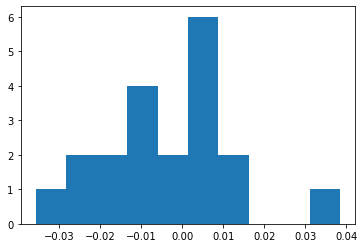

In [9]:
plt.hist(noise)

In [10]:
from scipy.signal import savgol_filter

In [11]:
test = np.sort(time)

In [12]:
diff = []
for i in range(len(test) - 1):
    diff.append(test[i + 1] - test[i])

diff

[0.063,
 0.24800000000000003,
 0.13499999999999995,
 0.17200000000000004,
 0.16999999999999993,
 0.09000000000000008,
 0.07299999999999995,
 0.07300000000000006,
 0.15700000000000003,
 0.07599999999999985,
 0.06400000000000006,
 0.03600000000000003,
 0.08899999999999997,
 0.01100000000000012,
 0.08499999999999996,
 0.04400000000000004,
 0.16999999999999993,
 0.09499999999999997,
 0.11299999999999999]

In [13]:
# src: https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

In [14]:
# 5 et 4 => 0.2633436061974125
# 7 et 6 => 0.26334353194149457
# 9 et 8 => 0.25909692222695624 meilleur
t_hat = non_uniform_savgol(time, temperature, 9, 8)

In [15]:
sum(abs(noise))

0.263343606257961

In [16]:
noise2 = real_temperature - t_hat

In [17]:
sum(abs(noise2))

0.25909692222695624

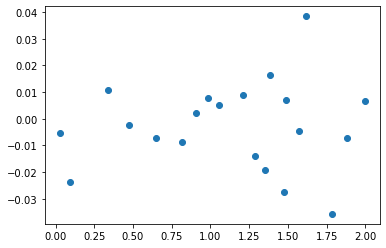

In [18]:
plt.scatter(time, noise2)

In [19]:
noises = []
for i in range(1, 20, 2):
    for j in range(i):
        t_hat = non_uniform_savgol(time, temperature, i, j)
        noise2 = real_temperature - t_hat
        somme_noise = sum(abs(noise2))
        noises.append([i, j, somme_noise])

In [20]:
noises = sorted(noises, key = lambda el: el[2])

In [21]:
noises[0]

[9, 8, 0.25909692222695624]

In [22]:
t_hat = non_uniform_savgol(time, temperature, 9, 8)

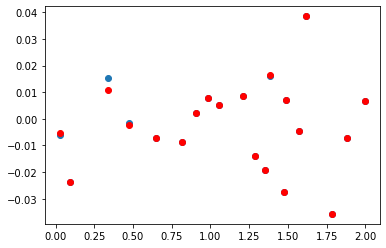

In [23]:
plt.scatter(time, real_temperature - temperature)
plt.scatter(time, real_temperature - t_hat, c = "red")

Ce n'est pas suffisant
# Autre méthode
Linéariser les input, interpoler les nouveaux points et utiliser savgol sur des données linéaires

In [24]:
x_lin = np.arange(start = 0, stop=2, step=2/len(time))
print(len(x_lin))
order = np.argsort(time)
time_sorted = time[order]
temperature_sorted = temperature[order]
y_lin = np.interp(x_lin, time_sorted, temperature_sorted)

20


In [25]:
from scipy.signal import savgol_filter

y_hat = savgol_filter(y_lin, 7, 3)

In [26]:
y_real = np.array([temperatureCalc(i, a, b, c) for i in x_lin])

In [27]:
sum(abs(y_lin - y_real))

2.930833099142685

In [28]:
sum(abs(y_hat - y_real))

2.5972019358840472

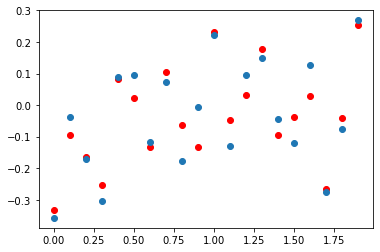

In [29]:
plt.scatter(x_lin, y_hat - y_real, c="red")
plt.scatter(x_lin, y_lin - y_real)

L'interpolation faire perdre trop de précision...

# Autre méthode

On enleve cos(pi\*x) au résultat de la température on applique non-uniform savgol et on rajoute cos(pi\*x)

In [50]:
temparature_flat = np.array([temperature[i] - np.cos(time[i] * np.pi) for i in range(len(time))])
temparature_flat_filtered = non_uniform_savgol(time, temparature_flat, 7, 6)
temperature_back_normal = np.array([temparature_flat_filtered[i] + np.cos(time[i] * np.pi) for i in range(len(time))])
noise_flat = real_temperature - temperature_back_normal
sum(abs(noise_flat))

0.263343524487953

In [38]:
# Find best value (7, 6)
values = []
for k in range(1, 20, 2):
    for l in range(k):
        temparature_flat = np.array([temperature[i] - np.cos(time[i] * np.pi) for i in range(len(time))])
        temparature_flat_filtered = non_uniform_savgol(time, temparature_flat, k, l)
        temperature_back_normal = np.array([temparature_flat_filtered[i] + np.cos(time[i] * np.pi) for i in range(len(time))])
        noise_flat = real_temperature - temperature_back_normal
        values.append([k, l, sum(abs(noise_flat))])

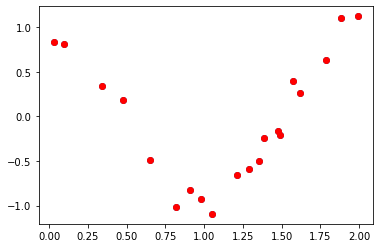

In [51]:
plt.scatter(time, temperature)
plt.scatter(time, temperature_back_normal, c="red")

Pas d'amélirations visible...

# Autre méthode

Test de FFT sur une courbe avec points également espacés

In [79]:
dt = .001
x_lin = np.arange(0, 2, dt)
y_lin = np.array([temperatureCalc(i, .16, 33, 5) + np.random.normal(0, .1) for i in x_lin])

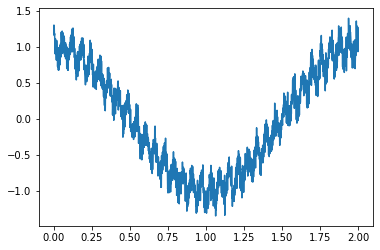

In [80]:
plt.plot(x_lin, y_lin)

C:\Users\Maax0\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-1.0, 100.0)

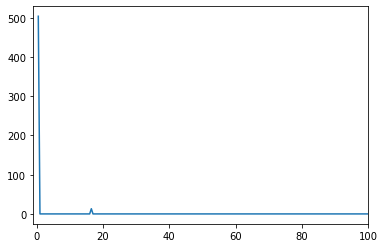

In [81]:
n = len(x_lin)
fhat = np.fft.fft(y_lin, n)
PSD = fhat * np.conj(fhat) / n
freq = (1 / (dt * n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype=int)

plt.plot(freq[L], PSD[L])
plt.xlim(-1, 100)

C:\Users\Maax0\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


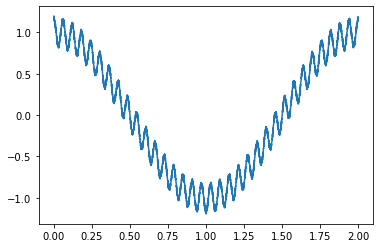

In [83]:
index = PSD > .1
fhat = fhat * index
y_corr = np.fft.ifft(fhat)
plt.plot(x_lin, y_corr)

Cela fonctionne bien, il faut tenter de faire une NFFT (points non également dispersés)